In [93]:
import os
import datetime
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline
import plotly.offline as py

# Read data

First of all, we have to load the on-disk data to the working memory. A great library to handle tabular data is **pandas**. The data was downloaded from https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data, feel free to explore!

In [61]:
df = pd.read_csv("../data/GlobalTemperatures.csv")

Let's check how the first rows look like:

In [62]:
df.head(3)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN


We will only use the first three columns: the date, an average temperature and an associated uncertainty measure.

In [73]:
df = df[["dt", "LandAverageTemperature", "LandAverageTemperatureUncertainty"]]

# change the datatype of date
df["dt"]= pd.to_datetime(df["dt"])

# remove NaN
df = df[~df["LandAverageTemperature"].isnull()]

df.dtypes

dt                                   datetime64[ns]
LandAverageTemperature                      float64
LandAverageTemperatureUncertainty           float64
dtype: object

# EDA

The first thing to do in *any* analysis is to explore the data so we can see what we're working with. This is the **E**xplorational **D**ata **A**nalysis part.

<Axes: >

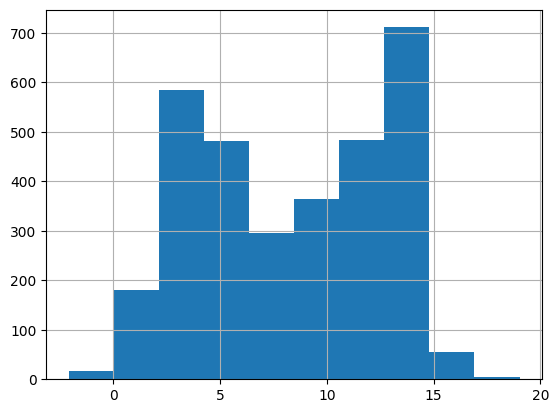

In [74]:
df["LandAverageTemperature"].hist()

We know that this column is measured in celsius. We see no real outliers, and temperatures generally range from 0 until 20.

<Axes: >

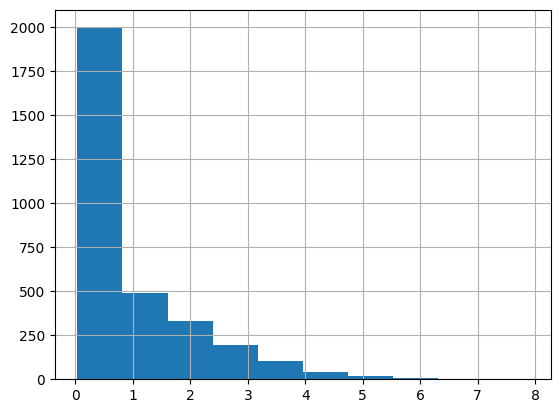

In [75]:
df["LandAverageTemperatureUncertainty"].hist()

The given uncertainty measure is the 95% confidence interval around the average and is generally quite low. However, it can take soms high values. We will see later when this tends to happen.

In [76]:
{"min": df["dt"].min(), "max": df["dt"].max()}

{'min': Timestamp('1750-01-01 00:00:00'),
 'max': Timestamp('2015-12-01 00:00:00')}

Can we see an effect of the month on the temperature? The figure below suggests we can!

<Axes: title={'center': 'LandAverageTemperature'}, xlabel='[month]'>

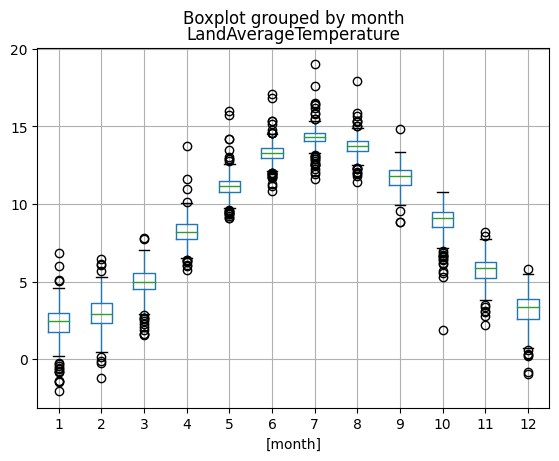

In [77]:
df["month"] = df.dt.dt.month
df.boxplot(column=['LandAverageTemperature'], by=['month'])

Let's do the same for the year, let's see if we can visualize the effect of global warming.

In [113]:
df["year"] = df.dt.dt.year
mean_temp_world = []
mean_temp_world_uncertainty = []

#for year in sorted(df["year"].unique()):
for year in df["year"]:
    mean_temp_world.append(df[df["year"] == year]['LandAverageTemperature'].mean())
    mean_temp_world_uncertainty.append(df[df["year"] == year]['LandAverageTemperatureUncertainty'].mean())

    trace0 = go.Scatter(
    x = df["year"], 
    y = np.array(mean_temp_world) + np.array(mean_temp_world_uncertainty),
    fill= None,
    mode='lines',
    name='Uncertainty top',
    line=dict(
        color='rgb(0, 255, 255)',
    )
)
trace1 = go.Scatter(
    x = df["year"], 
    y = np.array(mean_temp_world) - np.array(mean_temp_world_uncertainty),
    fill='tonexty',
    mode='lines',
    name='Uncertainty bot',
    line=dict(
        color='rgb(0, 255, 255)',
    )
)

trace2 = go.Scatter(
    x = df["year"], 
    y = mean_temp_world,
    name='Average Temperature',
    line=dict(
        color='rgb(199, 121, 093)',
    )
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in world',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

The plot above suggests that in fact, global warming is rising rapidly! Also, we can see that the 95% CI decreases in more recent times. Could you guess why?

In [135]:
# calculate average temperature per year
mean_temp_world = []
for year in sorted(df["year"].unique()):
    mean_temp_world.append(df[df["year"] == year]['LandAverageTemperature'].mean())
    
# show first 5 years
mean_temp_world[0:5]

[8.719363636363637,
 7.9761428571428565,
 5.7798333333333325,
 8.388083333333334,
 8.469333333333333]

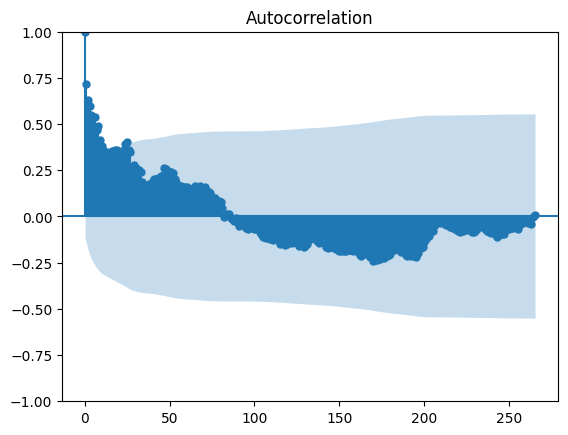

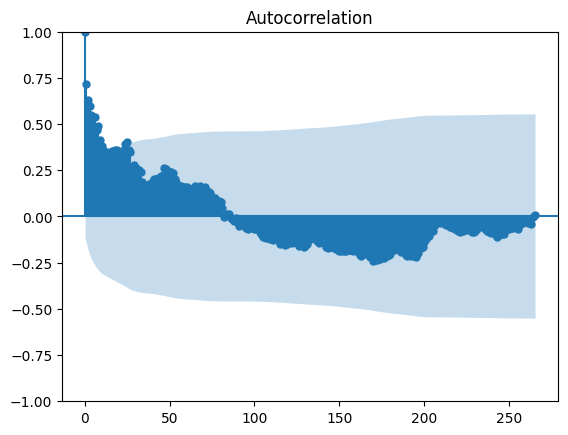

In [117]:
plot_acf(mean_temp_world, lags=len(mean_temp_world)-1)

Above is a figure of the autocorrelation, between a reference value (the oldest year) and another value. It shows the tendency for observations to be related to one another. The first value in the upper plot is 1, which makes sense because the first value can fully explain itself. When time goes on, this autocorrelation drops which also makes sense: older data has less predictive power on more recent timepoints. The ACF function even drops below zero: this means that if a past temperature is above the average temperature, a newer temperature is more likely to be below overage. You can read more about this here: http://www.pmean.com/09/NegativeAutocorrelation.html

The cone (lightblue) shows a 95% confidence interval, with which you can say something with statistical significance.

In [132]:
ex = pd.concat([pd.DataFrame(mean_temp_world).shift(3), pd.DataFrame(mean_temp_world).shift(2),
                       pd.DataFrame(mean_temp_world).shift(1), pd.DataFrame(mean_temp_world)], axis=1)
# naming the columns
ex.columns = ['t', 't+1', 't+2', 't+3']
 
# using corr() function to compute the correlation
result = ex.corr()
result

,t,t+1,t+2,t+3
t,1.000000,0.714860,0.636561,0.641452
t+1,0.714860,1.000000,0.719767,0.643927
t+2,0.636561,0.719767,1.000000,0.725075
t+3,0.641452,0.643927,0.725075,1.000000


This principle is shown in detail for the first three lags. It can be seen that a previous timepoint has a correlation of 0.71 to a next timepoint. When the size of lag increases (t+2, t+3), this autocorrelation decreases. Thus, when creating (linear) models, having information on the previous timepoint would be very important. 